In [12]:
%matplotlib inline
import sys
sys.path.insert(0,'..')
from IPython.display import HTML,Image,SVG,YouTubeVideo
from helpers import header

HTML(header())

## Active contour



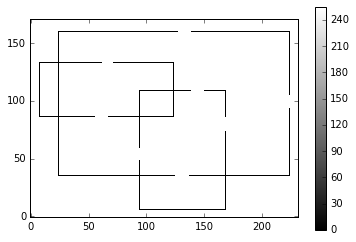

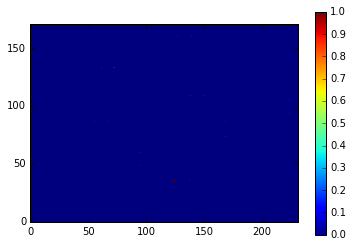

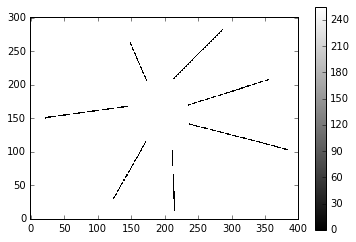

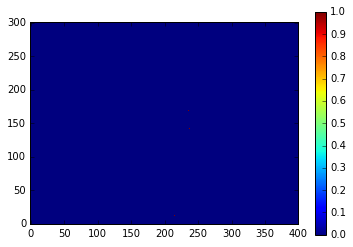

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as npy
from skimage.io import imread
from scipy import ndimage,interpolate
from scipy.ndimage.filters import convolve1d,gaussian_filter,convolve
from os.path import join

def Cx(ima):
    """x' derivative of image"""
    c = convolve1d(ima,npy.array([-1,0,1]),axis=1,cval=1)
    return c/2.0

def Cy(ima):
    """y' derivative of image"""
    c = convolve1d(ima,npy.array([-1,0,1]),axis=0,cval=1)
    return c/2.0

def Cxx(ima):
    """x'' derivative of image"""
    c = convolve1d(ima,npy.array([1,-2,1]),axis=1,cval=1)
    return c/4.0

def Cyy(ima):
    """y'' derivative of image"""
    c = convolve1d(ima,npy.array([1,-2,1]),axis=0,cval=1)
    return c/4.0

def Cxy(ima):
    """y'' derivative of image"""
    k = npy.array([[+1,0,-1],[0,0,0],[-1,0,+1]])
    c = convolve(ima,k)
    return c/4.0

def term(ima):
    cx = Cx(ima)
    cxx = Cxx(ima)
    cy = Cy(ima)
    cyy = Cyy(ima)
    cxy = Cxy(ima)

    num = cyy*(cx**2.0) + cxx*(cy**2.0) - 2.0 * (cxy*cx)*cy
    denom = npy.power(cx**2.0+cy**2,1.5)

    t = num/(denom+1.e-10)

    return t

data_path = 'http://homepages.ulb.ac.be/~odebeir/data'
filename = join(data_path,'lines.tif')

im = imread(filename).astype(float)

plt.figure(0)
plt.imshow(im,interpolation='nearest',cmap=cm.gray,origin='lower')
plt.colorbar()
plt.figure(1)
plt.imshow(term(im)>.5,interpolation='nearest',cmap=cm.jet,origin='lower')
plt.colorbar()

filename = join(data_path,'lines2.tif')

im = imread(filename).astype(float)

plt.figure(2)
plt.imshow(im,interpolation='nearest',cmap=cm.gray,origin='lower')
plt.colorbar()
plt.figure(3)
plt.imshow(term(im)>.5,interpolation='nearest',cmap=cm.jet,origin='lower')
plt.colorbar()

plt.show()

In [14]:
# -*- coding: utf-8 -*-
'''
Created on Nov 29, 2010

Attempt to port code found here :

http://www.iacl.ece.jhu.edu/static/gvf/

to python

@author: olivier
'''

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as scp
import numpy as npy
from scipy.ndimage.filters import gaussian_filter, convolve1d
from scipy.ndimage import map_coordinates
from numpy import linalg



def test_data(radius,filled=False):
    '''empty square, snakes is intialased on a centred circle

    :param radius: radius size relative to image size
    :type radius: float [0,1]

    :returns:  (xs,xy,image) snakes position and bitmap of the test image    
    '''
    im = npy.zeros((128,128))
    im[50:100,50:100] = 1.0
    if not filled:
        im[51:99,51:99] = 0.0
    theta = npy.linspace(0.0,2*npy.pi,20)
    r = im.shape[1]*radius
    xs = 0.5*r*npy.cos(theta) + 0.5*im.shape[1]
    ys = 0.5*r*npy.sin(theta) + 0.5*im.shape[0]
    return (xs,ys,im)

def gradients(image, sigma):
    smth = gaussian_filter(image.astype('float'), 6.0*sigma)
    xg = convolve1d(smth, [+0.5, 0, -0.5], axis=1)
    yg = convolve1d(smth, [+0.5, 0, -0.5], axis=0)
    return (xg,yg)


def snakeit(x,y,fx,fy,alpha=0.1,beta=0.1,gamma=1.0,kappa=1000,niter = 2):
    """
    compute new snakes position

    :param x,y: snakes position
    :type fx,fy: 1D arrays
    :param fx,fy: external force field
    :type fx,fy: 2D arrays
    :param alpha: elasticity
    :type alpha: float
    :param beta: rigidity
    :type beta: float
    :param gamma: viscosity
    :type gamma: float
    :param kappa: external forces weight
    :type kappa: float
    :param niter: number of iterations
    :type niter: int

    :returns:  (X,Y) snakes position after each iteration
    """

    N = len(x)

    a = beta
    b = -(alpha+4.*beta)
    c = 2.*alpha+6.*beta

    A = npy.zeros((N,N))
    id_main = npy.array(range(N))

    line = npy.hstack((npy.array([a,b,c,b,a]),npy.zeros((N-5,))))

    for i in range(N):
        idx = (id_main-i+2)%N
        A[i,:] = line[idx]

    AI = (A + gamma * npy.eye(N))
    invAI = linalg.inv(AI)

    h1 = None

    X = npy.zeros((niter+1,N))
    Y = npy.zeros((niter+1,N))

    for iter in range(niter):

        X[iter,:] = x
        Y[iter,:] = y

        vfx = map_coordinates(fx, [y, x])
        vfy = map_coordinates(fy, [y, x])

        fextx = kappa*vfx
        fexty = kappa*vfy
        fintx = gamma*x
        finty = gamma*y
        new_x = npy.dot(invAI, npy.transpose((fintx + fextx)))
        new_y = npy.dot(invAI, npy.transpose((finty + fexty)))

        x = new_x
        y = new_y

    X[niter,:] = x
    Y[niter,:] = y


    return (X,Y)

def snakeitp(x,y,fx,fy,alpha=0.5,beta=0.1,gamma=1.0,kappa=1000,kappap=0,niter = 2):
    """
    compute new snakes position using pressure

    :param x,y: snakes position
    :type fx,fy: 1D arrays
    :param fx,fy: external force field
    :type fx,fy: 2D arrays
    :param alpha: elasticity
    :type alpha: float
    :param beta: rigidity
    :type beta: float
    :param gamma: viscosity
    :type gamma: float
    :param kappa: external forces weight
    :type kappa: float
    :param kappap: pressure forces weight
    :type kappap: float
    :param niter: number of iterations
    :type niter: int

    :returns:  (X,Y) snakes position after each iteration
    """

    N = len(x)

    a = beta
    b = -(alpha+4.*beta)
    c = 2.*alpha+6.*beta

    A = npy.zeros((N,N))
    id_main = npy.array(range(N))

    line = npy.hstack((npy.array([a,b,c,b,a]),npy.zeros((N-5,))))

    for i in range(N):
        idx = (id_main-i+2)%N
        A[i,:] = line[idx]

    AI = (A + gamma * npy.eye(N))
    invAI = linalg.inv(AI)

    h1 = None

    X = npy.zeros((niter+1,N))
    Y = npy.zeros((niter+1,N))

    for iter in range(niter):

        X[iter,:] = x
        Y[iter,:] = y

        #external forces
        vfx = map_coordinates(fx, [y, x])
        vfy = map_coordinates(fy, [y, x])

        #pressure forces
        qx = npy.roll(x,-1)-npy.roll(x,1)
        qy = npy.roll(y,-1)-npy.roll(y,1)
        pmag = npy.sqrt(qx*qx+qy*qy)
        px = (qy/pmag)
        py = (-qx/pmag)

        fextx = kappa*vfx
        fexty = kappa*vfy 
        fintx = gamma*x + kappap*px
        finty = gamma*y + kappap*py
        new_x = npy.dot(invAI, npy.transpose((fintx + fextx)))
        new_y = npy.dot(invAI, npy.transpose((finty + fexty)))

        x = new_x
        y = new_y

    X[niter,:] = x
    Y[niter,:] = y

    return (X,Y)

def export_snakes(X,Y):
    '''save each position of the scake into a different image'''
    niter = X.shape[0]
    x = X[0,:]
    y = Y[0,:]
    h1 = None
    for iter in range(1,niter):
        new_x = X[iter,:]
        new_y = Y[iter,:]
        dx = new_x-x
        dy = new_y-y

        if h1 is not None:
            del plt.gca().lines[:]
            h2.remove()
            h3.remove()
        h1 = plt.plot(x,y,':k')
        h2 = plt.quiver(x, y, dx, -dy,alpha=.5,color = 'b',width=.005,scale=100)
        h3 = plt.text(10,10,'iteration: %d'%iter)

        x = new_x
        y = new_y

        plt.savefig('../../test/fig%04d.png'%iter, dpi=100)

def disp_snakes(X,Y):
    '''plot all the snakes positions in the same plot'''
    niter,n = X.shape
    x = X[0,:]
    y = Y[0,:]
    plt.plot(x,y,'or')
    for iter in range(1,niter):
        x = X[iter,:]
        y = Y[iter,:]
        plt.plot(x,y,':k')
        plt.text(x[iter%n],y[iter%n],'%d'%iter)
    plt.plot(x,y,'og')


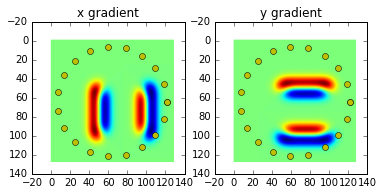

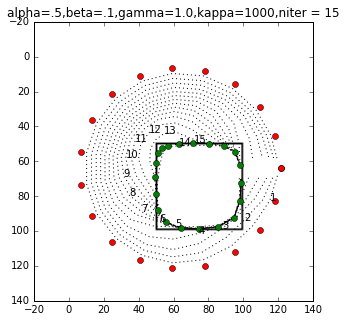

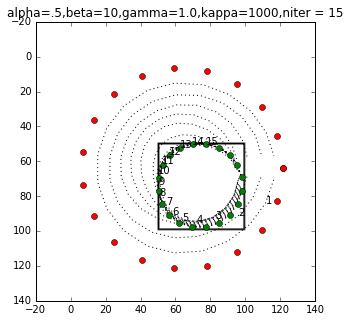

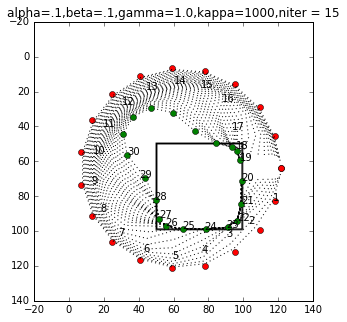

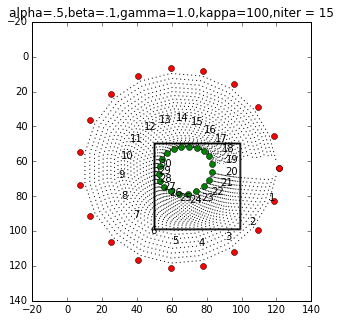

In [15]:
xs,ys,im = test_data(.9)

xg, yg = gradients(im,1)

plt.figure(0)
plt.subplot(1,2,1)
plt.imshow(xg)
plt.title('x gradient')
plt.plot(xs,ys,'oy')
plt.subplot(1,2,2)
plt.imshow(yg)
plt.plot(xs,ys,'oy')
plt.title('y gradient')

plt.figure(figsize=[5,5])
plt.imshow(im,cmap=cm.binary,alpha=1)
X,Y = snakeitp(xs,ys,xg,yg,alpha=.5,beta=.1,gamma=1.0,kappa=1000,kappap=0,niter = 15)
disp_snakes(X,Y)
plt.title('alpha=.5,beta=.1,gamma=1.0,kappa=1000,niter = 15')

plt.figure(figsize=[5,5])
plt.imshow(im,cmap=cm.binary,alpha=1)
X,Y = snakeitp(xs,ys,xg,yg,alpha=.5,beta=10,gamma=1.0,kappa=1000,kappap=0,niter = 15)
disp_snakes(X,Y)
plt.title('alpha=.5,beta=10,gamma=1.0,kappa=1000,niter = 15')

plt.figure(figsize=[5,5])
plt.imshow(im,cmap=cm.binary,alpha=1)
X,Y = snakeitp(xs,ys,xg,yg,alpha=.1,beta=.1,gamma=1.0,kappa=1000,kappap=0,niter = 30)
disp_snakes(X,Y)
plt.title('alpha=.1,beta=.1,gamma=1.0,kappa=1000,niter = 15')

plt.figure(figsize=[5,5])
plt.imshow(im,cmap=cm.binary,alpha=1)
X,Y = snakeitp(xs,ys,xg,yg,alpha=.5,beta=.1,gamma=1.0,kappa=100,kappap=0,niter = 30)
disp_snakes(X,Y)
plt.title('alpha=.5,beta=.1,gamma=1.0,kappa=100,niter = 15')


plt.show()